In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.clip_grad import clip_grad_norm_
import torch.distributions as distributions

import numpy as np
import matplotlib.pyplot as plt

import datetime
import itertools

from torch.utils.tensorboard import SummaryWriter

from collections import namedtuple, deque
import random

import gym

In [21]:
class Memory:
    """
    Fixed -size buffe to store experience tuples.
    
    Params
    ======
        action_size (int): dimension of each action
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch

    """
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.state_size = state_size
        
        self.states = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        
    def push(self,state, log_prob, reward, done):
        """
        Adds an observation to the replay buffer
        """
        self.states.append(torch.FloatTensor(state))
        self.log_probs.append(torch.FloatTensor(log_prob))
        self.rewards.append(torch.FloatTensor([reward]))
        self.dones.append(torch.LongTensor([done]))             

    def pull(self):
        """
        Randomly sample a batch of observations from memory
        """
        states = torch.cat(self.states).view(-1, self.state_size)
        log_probs = torch.cat(self.log_probs)
        rewards = torch.cat(self.rewards)
        dones = torch.cat(self.dones)
        self.reset()
        return states, log_probs, rewards, dones
    
    def reset(self):
        self.__init__(self.state_size, self.action_size)
        
    def __len__(self):
        return len(self.memory)

In [22]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = distributions.Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [23]:
class Agent():
    """
    Actor-critic algorithm. Optimizes the policy function using policy gradient
    
    Args:
        env: OpenAI environment
        policy: Action policy parameterized by a neural network
        num_episodes: number of episodes to be ran
        discount_factor: discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = Memory(state_size, action_size)
        
        self.writer = SummaryWriter(log_dir = './content/runs/a2c-cartpole')
        
        self.actor = Actor(self.state_size, self.action_size)
        self.critic = Critic(self.state_size, self.action_size)
        
        self.a_optimizer = optim.Adam(self.actor.parameters(), lr = LR)
        self.c_optimizer = optim.Adam(self.critic.parameters(), lr = LR)
    
        
    def take_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)         
        dist = self.actor(state)
        value = self.critic(state)
        return dist, value
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)  
        
    def compute_returns(self,rewards, gamma=0.99):
        R = 0
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + gamma * R
            returns.insert(0, R)
        return torch.tensor(returns)
    
    
    def train(self):
        states, log_probs, rewards, dones = self.memory.pull()
        values = self.critic(states)            
        returns = self.compute_returns(rewards, GAMMA).detach()
        returns = (returns - returns.mean()) / np.std(returns.numpy())
        advantage = returns - values     
               
        self.a_optimizer.zero_grad()
        self.c_optimizer.zero_grad()
        
        loss_critic = advantage.pow(2).mean()
        loss_actor = -(log_probs * advantage.detach()).mean()
        
        total_loss = loss_critic + loss_actor
        total_loss.backward()
        
        self.a_optimizer.step()
        self.c_optimizer.step()
        


In [27]:
GAMMA = 0.99
LR = 0.001

agent = Agent(env.observation_space.shape[0], env.action_space.n)


def a2c(agent, num_episodes = 1000):
    scores = []
    for i in range(num_episodes):
        state = env.reset()
        episode_score = 0      
        for t in itertools.count():            
            distribution, value = agent.take_action(state)    
            action = distribution.sample()
            print(action)
            next_state, reward, done, _ = env.step(action)  
           
            agent.memory.push(state, distribution.log_prob(action), reward, done)
            episode_score += reward
            
            state = next_state        
            if done:
                scores.append(episode_score) 
                break
                
        agent.train()     
        
        if np.mean(scores[-100:]) >= 195:
            print(f"Environment solved! It took {i} episodes to get an average reward of {np.mean(scores[-100:])}")
            break
        
        if i % 100 == 99:
            print(f"Episode {i+1} \tAverage reward {np.around(np.mean(scores[-100:]))}")
            
        
    return scores

scores = a2c(agent)


BrokenPipeError: [WinError 232] The pipe is being closed

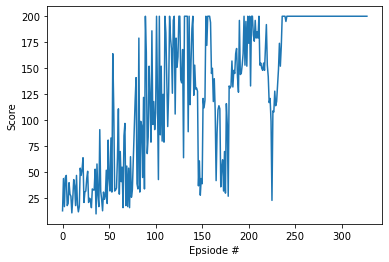

In [1499]:

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')

plt.show()

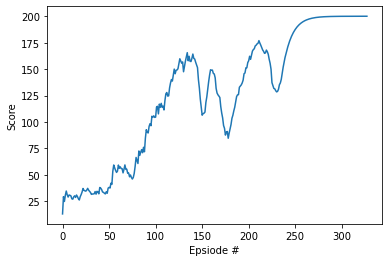

In [1504]:
def moving_average(scores, beta = 0.9):
    
    moving_average = 0
    smoothed = []
    for i in range(len(scores)):
        moving_average = (beta * moving_average + (1-beta) * scores[i])
        smoothed.append(moving_average/(1-beta**(i+1)))

    plt.plot(np.arange(len(smoothed)),smoothed)
    plt.ylabel('Score')
    plt.xlabel('Epsiode #')

    plt.show()
    
moving_average(scores, 0.9)

In [7]:
from typing import Callable
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

def make_env(env_id: str, rank: int, seed: int = 0) -> Callable:
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """
    def _init() -> gym.Env:
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [8]:
env = SubprocVecEnv([make_env("CartPole-v0", i) for i in range(4)])

In [9]:
env